In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
df_r_001_s_005 = pd.read_csv("data/mean/temp_sig0.05_r0.01.txt", sep="\t")
df_r_001_s_01 = pd.read_csv("data/mean/temp_sig0.1_r0.01.txt", sep="\t")
df_r_001_s_05 = pd.read_csv("data/mean/temp_sig0.5_r0.01.txt", sep="\t")

df_r_005_s_005 = pd.read_csv("data/mean/temp_sig0.05_r0.05.txt", sep="\t")
df_r_005_s_01 = pd.read_csv("data/mean/temp_sig0.1_r0.05.txt", sep="\t")
df_r_005_s_05 = pd.read_csv("data/mean/temp_sig0.5_r0.05.txt", sep="\t")

df_r_01_s_005 = pd.read_csv("data/mean/temp_sig0.05_r0.1.txt", sep="\t")
df_r_01_s_01 = pd.read_csv("data/mean/temp_sig0.1_r0.1.txt", sep="\t")
df_r_01_s_05 = pd.read_csv("data/mean/temp_sig0.5_r0.1.txt", sep="\t")

df_all_mean = pd.concat((df_r_001_s_005, df_r_001_s_01, df_r_001_s_05, 
                    df_r_005_s_005, df_r_005_s_01, df_r_005_s_05,
                    df_r_01_s_005, df_r_01_s_01, df_r_01_s_05), ignore_index=True)

In [11]:
df_mean_mean = df_all_mean.groupby(["r", "sigma"], as_index=False).mean()

In [12]:
df_mean_mean

,r,sigma,scene_id,ade,fde,abd,fbd
0,0.01,0.05,710.017165,0.561490,1.196024,2.283751,2.117378
1,0.01,0.10,710.017165,0.594069,1.246066,1.172176,1.090146
2,0.01,0.50,710.017165,0.839427,1.620344,0.274974,0.260446
3,0.05,0.05,710.017165,0.561329,1.194686,10.140477,9.580723
4,0.05,0.10,710.017165,0.593372,1.244276,5.686684,5.315468
5,0.05,0.50,710.017165,0.841076,1.622002,1.375492,1.303030
6,0.10,0.05,710.017165,0.560539,1.194769,14.988954,14.667803
7,0.10,0.10,710.017165,0.594628,1.246115,10.363546,9.819495
8,0.10,0.50,710.017165,0.845402,1.628395,2.737443,2.594348


In [13]:
df_mean_mean.index

RangeIndex(start=0, stop=9, step=1)

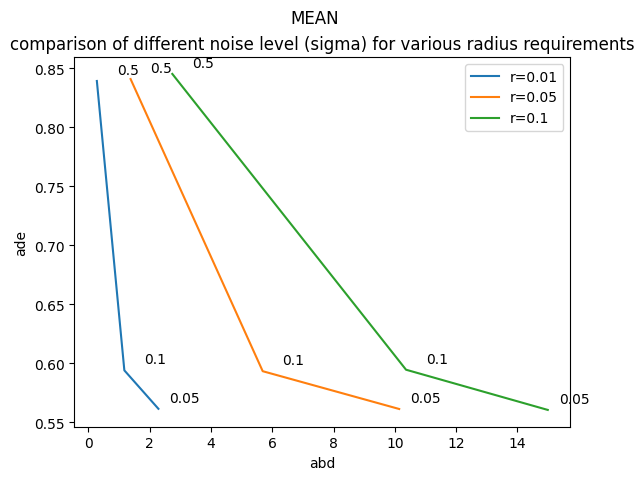

In [25]:
fig, ax = plt.subplots()
df_mean_mean
[ax.plot(df_mean_mean[df_mean_mean["r"] == r]["abd"], df_mean_mean[df_mean_mean["r"] == r]["ade"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="abd", ylabel="ade")
plt.legend()
plt.suptitle("MEAN")

for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_mean_mean[df_mean_mean["r"] == r]["abd"],df_mean_mean[df_mean_mean["r"] == r]["ade"])):

        label = str(df_mean_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(30,5), # distance from text to points (x,y)
                    ha='right')

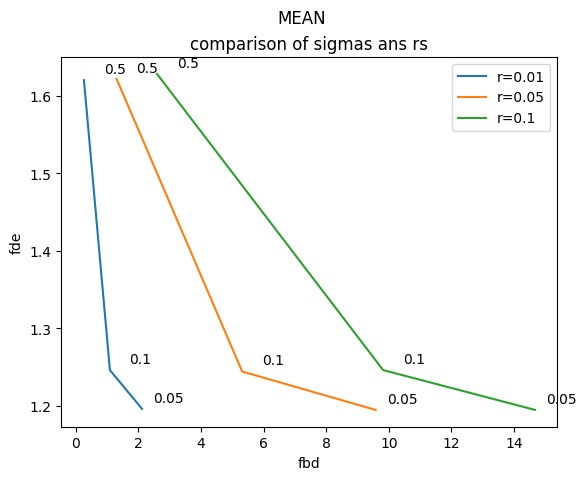

In [27]:
fig, ax = plt.subplots()
[ax.plot(df_mean_mean[df_mean_mean["r"] == r]["fbd"], df_mean_mean[df_mean_mean["r"] == r]["fde"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of sigmas ans rs", xlabel="fbd", ylabel="fde")
plt.legend()
plt.suptitle("MEAN")

for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_mean_mean[df_mean_mean["r"] == r]["fbd"],df_mean_mean[df_mean_mean["r"] == r]["fde"])):

        label = str(df_mean_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(30,5), # distance from text to points (x,y)
                    ha='right')

# with median 1

In [16]:
df_r_001_s_005 = pd.read_csv("data/med1/temp_sig0.05_r0.01.txt", sep="\t")
df_r_001_s_01 = pd.read_csv("data/med1/temp_sig0.1_r0.01.txt", sep="\t")
df_r_001_s_05 = pd.read_csv("data/med1/temp_sig0.5_r0.01.txt", sep="\t")

df_r_005_s_005 = pd.read_csv("data/med1/temp_sig0.05_r0.05.txt", sep="\t")
df_r_005_s_01 = pd.read_csv("data/med1/temp_sig0.1_r0.05.txt", sep="\t")
df_r_005_s_05 = pd.read_csv("data/med1/temp_sig0.5_r0.05.txt", sep="\t")

df_r_01_s_005 = pd.read_csv("data/med1/temp_sig0.05_r0.1.txt", sep="\t")
df_r_01_s_01 = pd.read_csv("data/med1/temp_sig0.1_r0.1.txt", sep="\t")
df_r_01_s_05 = pd.read_csv("data/med1/temp_sig0.5_r0.1.txt", sep="\t")

df_all_med1 = pd.concat((df_r_001_s_005, df_r_001_s_01, df_r_001_s_05, 
                    df_r_005_s_005, df_r_005_s_01, df_r_005_s_05,
                    df_r_01_s_005, df_r_01_s_01, df_r_01_s_05), ignore_index=True)

In [18]:
df_med1_mean = df_all_med1.groupby(["r", "sigma"], as_index=False).mean()

In [20]:
df_med1_mean

,r,sigma,scene_id,ade,fde,abd,fbd
0,0.01,0.05,710.017165,0.568305,1.198737,2.283699,2.117184
1,0.01,0.10,710.017165,0.605967,1.252051,1.172167,1.090048
2,0.01,0.50,710.017165,0.880531,1.590744,0.274961,0.260382
3,0.05,0.05,710.017165,0.567788,1.196975,10.140213,9.580026
4,0.05,0.10,710.017165,0.606395,1.251170,5.686633,5.314972
5,0.05,0.50,710.017165,0.888437,1.597930,1.375432,1.302711
6,0.10,0.05,710.017165,0.568541,1.199886,14.988898,14.667498
7,0.10,0.10,710.017165,0.607478,1.251299,10.363377,9.818592
8,0.10,0.50,710.017165,0.887665,1.593811,2.737342,2.593831


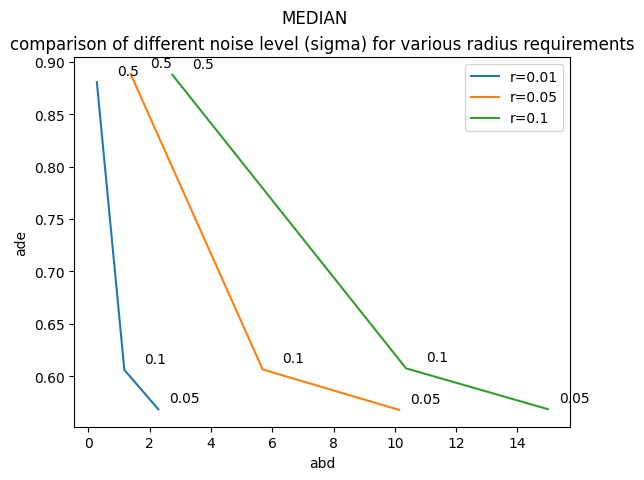

In [24]:
fig, ax = plt.subplots()

[ax.plot(df_med1_mean[df_med1_mean["r"] == r]["abd"], df_med1_mean[df_med1_mean["r"] == r]["ade"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="abd", ylabel="ade")
plt.suptitle("MEDIAN")
plt.legend()

for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_med1_mean[df_med1_mean["r"] == r]["abd"],df_med1_mean[df_med1_mean["r"] == r]["ade"])):

        label = str(df_med1_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(30,5), # distance from text to points (x,y)
                    ha='right')

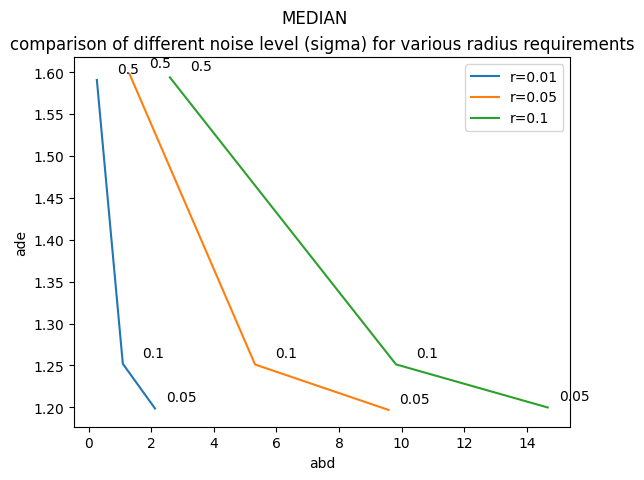

In [28]:
fig, ax = plt.subplots()

[ax.plot(df_med1_mean[df_med1_mean["r"] == r]["fbd"], df_med1_mean[df_med1_mean["r"] == r]["fde"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="abd", ylabel="ade")
plt.suptitle("MEDIAN")
plt.legend()

for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_med1_mean[df_med1_mean["r"] == r]["fbd"],df_med1_mean[df_med1_mean["r"] == r]["fde"])):

        label = str(df_med1_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(30,5), # distance from text to points (x,y)
                    ha='right')

# mean vs med1 vs med 2 for fix r

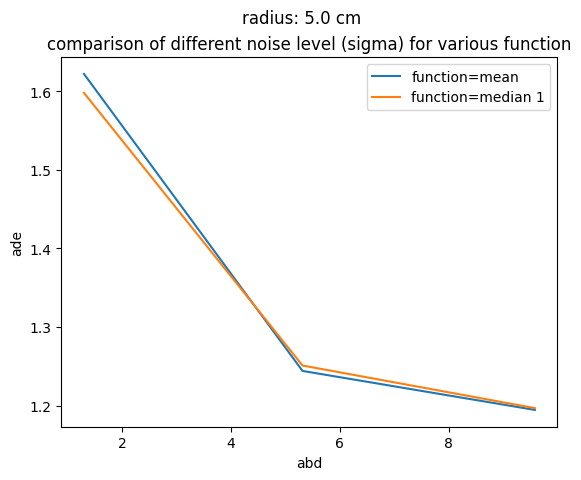

In [37]:
fig, ax = plt.subplots()
r = 0.05 # 5 cm
func_name = ["mean", "median 1"]
[ax.plot(df[df["r"] == r]["fbd"], df[df["r"] == r]["fde"], label = f"function={func_name[i]}") for i, df in enumerate([df_mean_mean, df_med1_mean])]
ax.set(title="comparison of different noise level (sigma) for various function", xlabel="abd", ylabel="ade")
plt.suptitle(f"radius: {r*100} cm")
plt.legend()